In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/model1/keras/default/1/yelp_review_model1.keras


In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import os
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import re
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

In [3]:
def load_data(path, filename, truncate=None):
    data_file = open(os.path.join(path, filename))
    data = []
    if truncate is not None:
        for i, line in enumerate(data_file):
            data.append(json.loads(line))
            if i == truncate:
                break
        # for line in data_file[0:truncate]:
        #     data.append(json.loads(line))
    else:
        for line in data_file:
            data.append(json.loads(line))
    ret_df = pd.DataFrame(data)
    data_file.close()
    return ret_df

path = "/kaggle/input/yelp-dataset"

businesses_df = load_data(path, "yelp_academic_dataset_business.json")
reviews_df = load_data(path, "yelp_academic_dataset_review.json", truncate=10000)
tips_df = load_data(path, "yelp_academic_dataset_tip.json")

In [4]:
display(businesses_df)

display(reviews_df)

display(tips_df)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
9996,UIkEO-10J6Y99IhRqUflvg,lYAmgL_l7A3MPFYe1DYKrw,EpREWeEpmR8f1qLHzzF0AA,5.0,0,1,0,Just about to get tucked into a meatloaf that ...,2018-01-09 20:26:13
9997,S-NQM3Axcg8JS3MXHUIvyw,rE2WwfgJbYfvDwBlgq__dQ,dvidzWEPgTQPeBc8CUV2OQ,5.0,0,0,0,Outstanding customer service! And my car is dr...,2015-04-01 21:50:28
9998,ME79YrEhm2xe4IQy_0zkGw,OnIklvzKDpk1BduC84TrTA,2XYPFRm7teCUr3eGsB2-qw,5.0,0,0,0,I and my husband went here for Dinner one day ...,2015-06-08 19:32:26
9999,05oKtleZ-JFGD6qt47VQcg,p0MhNWkwOPBfRo8qUb7faw,rnaE88k8yV5pFAGJeiIK4Q,2.0,0,0,0,I saw Big Data when they came to town at the K...,2015-08-06 23:16:58


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0
...,...,...,...,...,...
908910,eYodOTF8pkqKPzHkcxZs-Q,3lHTewuKFt5IImbXJoFeDQ,Disappointed in one of your managers.,2021-09-11 19:18:57,0
908911,1uxtQAuJ2T5Xwa_wp7kUnA,OaGf0Dp56ARhQwIDT90w_g,Great food and service.,2021-10-30 11:54:36,0
908912,v48Spe6WEpqehsF2xQADpg,hYnMeAO77RGyTtIzUSKYzQ,Love their Cubans!!,2021-11-05 13:18:56,0
908913,ckqKGM2hl7I9Chp5IpAhkw,s2eyoTuJrcP7I_XyjdhUHQ,Great pizza great price,2021-11-20 16:11:44,0


In [5]:
print(len(reviews_df['business_id'].unique()))

3930


In [6]:
def filter_business_reviews(df, num_reviews):
    business_and_num_reviews = {}
    for index in df.index:
        business_id = df.loc[index,'business_id']
        if business_id in business_and_num_reviews.keys():
            business_and_num_reviews[business_id] += 1
        else:
            business_and_num_reviews[business_id] = 1
    bus_over_num = []
    for key, value in business_and_num_reviews.items():
        if value >= num_reviews:
            bus_over_num.append(key)
    return df[df['business_id'].isin(bus_over_num)]

reviews_df = filter_business_reviews(reviews_df, 30)
    

In [7]:
# the businesses in the db that are open vs those not open
businesses_open = businesses_df[businesses_df['is_open'] == 1]
print("Businesses open: ", len(businesses_open))

businesses_closed = businesses_df[businesses_df['is_open'] == 0]
print("Businesses closed: ", len(businesses_closed))

Businesses open:  119698
Businesses closed:  30648


In [8]:
all_unique_cats = {}

for index, row in businesses_df.iterrows():
    if not row['categories']:
        continue
        
    diff_cats = row['categories'].split(", ")
    for cat in diff_cats:
        if cat in all_unique_cats:
            all_unique_cats[cat] += 1
        else:
            all_unique_cats[cat] = 1

sorted_cats = sorted(all_unique_cats.items(), key=lambda x: x[1], reverse=True)
print("Top 10 categories: ", sorted_cats[:10])

Top 10 categories:  [('Restaurants', 52268), ('Food', 27781), ('Shopping', 24395), ('Home Services', 14356), ('Beauty & Spas', 14292), ('Nightlife', 12281), ('Health & Medical', 11890), ('Local Services', 11198), ('Bars', 11065), ('Automotive', 10773)]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Restaurants'),
  Text(1, 0, 'Food'),
  Text(2, 0, 'Shopping'),
  Text(3, 0, 'Home Services'),
  Text(4, 0, 'Beauty & Spas'),
  Text(5, 0, 'Nightlife'),
  Text(6, 0, 'Health & Medical'),
  Text(7, 0, 'Local Services'),
  Text(8, 0, 'Bars'),
  Text(9, 0, 'Automotive'),
  Text(10, 0, 'Event Planning & Services'),
  Text(11, 0, 'Sandwiches'),
  Text(12, 0, 'American (Traditional)'),
  Text(13, 0, 'Active Life'),
  Text(14, 0, 'Pizza'),
  Text(15, 0, 'Coffee & Tea'),
  Text(16, 0, 'Fast Food'),
  Text(17, 0, 'Breakfast & Brunch'),
  Text(18, 0, 'American (New)'),
  Text(19, 0, 'Hotels & Travel'),
  Text(20, 0, 'Home & Garden'),
  Text(21, 0, 'Fashion'),
  Text(22, 0, 'Burgers'),
  Text(23, 0

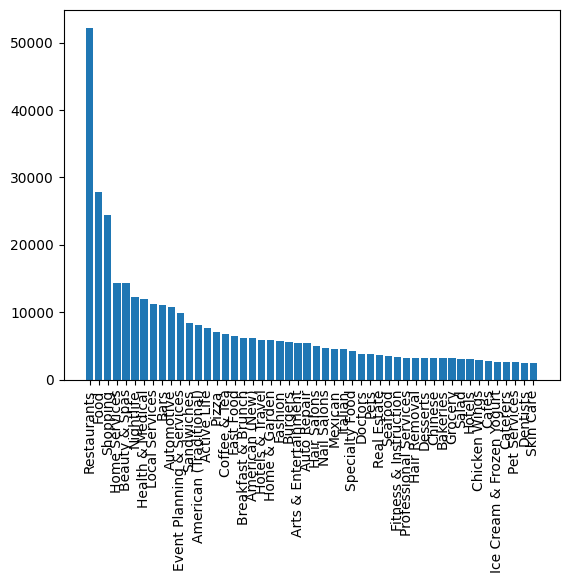

In [9]:
num_cats = 50
plt.bar([x[0] for x in sorted_cats[:num_cats]], [x[1] for x in sorted_cats[:num_cats]])
plt.xticks(rotation=90)

In [10]:
businesses_df["categories"] = businesses_df["categories"].apply(lambda x: x.split(", ") if x else "")

businesses_df["categories"] = businesses_df["categories"].apply(lambda x: [cat for cat in x if cat != "Restaurants"])

reviews_business_df = pd.merge(reviews_df, businesses_df, on="business_id")

reviews_business_df

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,pHwbdway4yeI-dSSmZA7-Q,qEEk0PuoH1dVa619t8fgpw,PY9GRfzr4nTZeINf346QOw,4.0,0,0,0,We checked in around 2:30 pm. Check-in was qu...,2017-09-20 16:16:47,Peppermill Reno,...,NV,89502,39.497687,-119.801139,4.0,2486,1,"{'RestaurantsPriceRange2': '2', 'ByAppointment...","[Event Planning & Services, Casinos, Beauty & ...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
1,jC-fGfx-YLqxVBcyTAd4Pw,EBa-0-6AKoy6jziNexDJtg,W4ZEKkva9HpAdZG88juwyQ,3.0,0,0,0,"In a word... ""OVERRATED!"". The food took fore...",2013-12-29 02:37:42,Mr. B's Bistro,...,LA,70130,29.954387,-90.068363,4.0,2064,1,"{'NoiseLevel': 'u'average'', 'RestaurantsReser...","[Bars, Breakfast & Brunch, Barbeque, Cajun/Cre...","{'Wednesday': '11:30-20:0', 'Thursday': '11:30..."
2,cvQXRFLCyr0S7EgFb4lZqw,ZGjgfSvjQK886kiTzLwfLQ,EtKSTHV5Qx_Q7Aur9o4kQQ,5.0,3,1,1,"On a scale of one to things that are awesome, ...",2009-10-14 01:15:04,Village Whiskey,...,PA,19103,39.951417,-75.173768,4.0,1553,1,"{'RestaurantsReservations': 'False', 'Restaura...","[Bars, Nightlife, Whiskey Bars, Burgers, Ameri...","{'Wednesday': '16:0-21:0', 'Thursday': '16:0-2..."
3,4zopEEPqfwm-c_FNpeHZYw,JYYYKt6TdVA4ng9lLcXt_g,SZU9c8V2GuREDN5KgyHFJw,5.0,0,0,0,We were a bit weary about trying the Shellfish...,2016-05-31 02:14:54,Santa Barbara Shellfish Company,...,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","[Live/Raw Food, Seafood, Beer Bar, Beer, Wine ...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
4,yyrMqY7sNp5gT7KJ1AaYWA,pitYOVSsF8R1gWG1G0qxsA,GBTPC53ZrG1ZBY3DT8Mbcw,4.0,0,0,0,We have been here twice for brunch and have en...,2016-03-07 17:25:30,Luke,...,LA,70130,29.950742,-90.070416,4.0,4554,1,"{'RestaurantsReservations': 'True', 'Restauran...","[German, Seafood, Cocktail Bars, French, Brass...","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,B42g5xZQAgw0IQojbAZUXQ,q34MA5yPVVEkIV2mldl0jw,GBTPC53ZrG1ZBY3DT8Mbcw,5.0,0,0,0,Was visiting NoLa and happy I came to Luke eve...,2014-12-17 22:45:48,Luke,...,LA,70130,29.950742,-90.070416,4.0,4554,1,"{'RestaurantsReservations': 'True', 'Restauran...","[German, Seafood, Cocktail Bars, French, Brass...","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."
461,AObyZTlCo1VyrsKUFYC1MA,EEJZi7OjIY21ec-KXDa15Q,SZU9c8V2GuREDN5KgyHFJw,3.0,1,0,0,(only a three star review because we were only...,2010-03-13 20:36:51,Santa Barbara Shellfish Company,...,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","[Live/Raw Food, Seafood, Beer Bar, Beer, Wine ...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
462,hpNTU_zrpFUW4-TonIOJ1g,ySQP6km_KmfSQ48h1FxqLw,M0r9lUn2gLFYgIwIfG8-bQ,5.0,0,0,0,Recently moved away from St. Louis and I miss ...,2015-05-26 14:27:57,Baileys' Range,...,MO,63101,38.628864,-90.194542,3.5,1567,1,"{'OutdoorSeating': 'False', 'RestaurantsAttire...","[Ice Cream & Frozen Yogurt, Burgers, Food, Nig...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
463,FZBAZG-wWaSUAok7w8XSOQ,26F2byB18-dq7319tJHXrA,UCMSWPqzXjd7QHq7v8PJjQ,5.0,0,0,0,Love their food & Mimosas. Appreciate the sec...,2017-09-09 15:37:17,Prep & Pastry,...,AZ,85719,32.255528,-110.943492,4.5,2126,1,"{'Alcohol': 'u'full_bar'', 'BikeParking': 'Tru...","[Cocktail Bars, Bars, Comfort Food, American (...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-15:0', '..."


In [11]:
all_cats = [x[0] for x in sorted_cats[:num_cats]]

mlb = sklearn.preprocessing.MultiLabelBinarizer()

y = mlb.fit_transform(reviews_business_df["categories"])

In [12]:
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews_business_df["text"])

X = tokenizer.texts_to_sequences(reviews_business_df["text"])
X = pad_sequences(X, maxlen=max_len, padding="post", truncating="post")

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
reviews_business_df["text"]

0      We checked in around 2:30 pm.  Check-in was qu...
1      In a word... "OVERRATED!".  The food took fore...
2      On a scale of one to things that are awesome, ...
3      We were a bit weary about trying the Shellfish...
4      We have been here twice for brunch and have en...
                             ...                        
460    Was visiting NoLa and happy I came to Luke eve...
461    (only a three star review because we were only...
462    Recently moved away from St. Louis and I miss ...
463    Love their food & Mimosas.  Appreciate the sec...
464    I recommend getting the migas. We had to wait ...
Name: text, Length: 465, dtype: object

In [15]:
y

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Prof's model

In [14]:

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation="relu"),
    Dense(y.shape[1], activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Takes approx. 5 mins
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250, batch_size=32)


Epoch 1/250


KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["accuracy"])
plt.show()
plt.plot(history.history["val_accuracy"])
plt.show()

plt.plot(history.history["loss"])
plt.show()
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
y_val[4]

In [ ]:
# For predicting from the entire data corpus:

# rand_num = np.random.randint(0, len(reviews_business_df))
# the_text = reviews_business_df["text"][rand_num]
# display(the_text)
# sequence = tokenizer.texts_to_sequences([the_text])
# padded_sequence = pad_sequences(sequence, maxlen=max_len, padding="post", truncating="post")
# pred = model.predict(padded_sequence)

rand_num = np.random.randint(0, X_val.shape[0])
pred = model.predict(X_val[rand_num].reshape(1, -1))

pred_labels = mlb.inverse_transform((pred > 0.5).astype(int))

print("Predicted:", str(pred_labels))

print("Actual: ", mlb.inverse_transform(y_val[rand_num].reshape(1, -1)))

# print("Actual: ", reviews_business_df["categories"][rand_num])

# Save a model

In [ ]:
if not os.path.exists('models'):
    os.mkdir('models', )
num = 0
path = os.path.join('models', f'yelp_review_model{num}.keras')
while path in os.listdir('models'):
    num += 1
    path = os.path.join('models', f'yelp_review_model{num}.keras')
model.save(path)

# Extract from pre-made model

In [ ]:
model = tf.keras.models.load_model("/kaggle/input/model1/keras/default/1/yelp_review_model1.keras")

# BERT Model

In [16]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, BertConfig,BertTokenizer,get_linear_schedule_with_warmup
from torch.optim import AdamW

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
mlb = sklearn.preprocessing.MultiLabelBinarizer()

y = mlb.fit_transform(reviews_business_df["categories"])

In [17]:
reviews_df["text"].apply(lambda x : len(x))

37      1369
44       363
49       934
61      1770
108      227
        ... 
9947     114
9960     934
9976     435
9977     126
9978     180
Name: text, Length: 465, dtype: int64

In [18]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [19]:
reviews_df = reviews_df.reset_index()

In [20]:


print(' Original: ', reviews_df["text"][0])
print("\n\n\n\n")

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(reviews_df["text"][0]))
print("\n\n\n\n")

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews_df["text"][0])))

 Original:  We checked in around 2:30 pm.  Check-in was quick and easy with complimentary valet parking (always appreciated).  The Peppermill is huge and reminded us of the Caesars Palace in Las Vegas.  They have around eight restaurants on site offering almost any type of food you could want.  The casino area is huge, rivaling almost anything you could find in Las Vegas.  One thing we noticed is that many of the slot machines were noted as being penny machines, but when you actually started to play them you realized they had minimum bets of anywhere from 30 cents to $5.  Talk about false advertising!  We were in the Tuscany Tower on the 12th floor.  Our room had a nice view of the huge pool area.  Our room was large and featured free WiFi (likewise always appreciated), a huge bathroom area with large shower (with two shower heads), TV, a large jetted bathtub and a phone next to the commode.  There were dual sinks and lots of counter space.  Plenty of towels were supplied.  The roomy m

In [21]:
max_len = 0

# For every sentence...
for sent in reviews_df["text"]:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, max_length=512, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))



print('Max sentence length: ', max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length:  512


In [22]:
max_len=512

In [23]:
input_ids = []
attention_masks = []

# For every tweet...
for tweet in reviews_df["text"]:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', reviews_df["text"][0])
print('Token IDs:', input_ids[0])


Original:  We checked in around 2:30 pm.  Check-in was quick and easy with complimentary valet parking (always appreciated).  The Peppermill is huge and reminded us of the Caesars Palace in Las Vegas.  They have around eight restaurants on site offering almost any type of food you could want.  The casino area is huge, rivaling almost anything you could find in Las Vegas.  One thing we noticed is that many of the slot machines were noted as being penny machines, but when you actually started to play them you realized they had minimum bets of anywhere from 30 cents to $5.  Talk about false advertising!  We were in the Tuscany Tower on the 12th floor.  Our room had a nice view of the huge pool area.  Our room was large and featured free WiFi (likewise always appreciated), a huge bathroom area with large shower (with two shower heads), TV, a large jetted bathtub and a phone next to the commode.  There were dual sinks and lots of counter space.  Plenty of towels were supplied.  The roomy ma

In [24]:
len(input_ids[0])

512

In [25]:
new_reviews_business_merge = pd.merge(reviews_df, businesses_df, on='business_id', how='inner')

In [26]:
labels = mlb.fit_transform(new_reviews_business_merge["categories"])

display(labels.shape)

num_labels = labels.shape[1]

labels = torch.tensor(labels)

(465, 37)

In [27]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  372 training samples
   93 validation samples


In [28]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [29]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = num_labels, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    # config=config
)

# if device == "cuda:0":
# Tell pytorch to run this model on the GPU.
#     model = model.cuda()
# model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [31]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [32]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_labels = batch[2].to(device).squeeze()
        optimizer.zero_grad()

        print(f"b_input_ids shape: {b_input_ids.shape}")   # Should be (batch_size, seq_length)
        print(f"b_input_mask shape: {b_input_mask.shape}") # Should be (batch_size, seq_length)
        print(f"b_labels shape: {b_labels.shape}")         # Should be (batch_size,) or (batch_size, num_classes)
        
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
b_input_ids shape: torch.Size([32, 512])
b_input_mask shape: torch.Size([32, 512])
b_labels shape: torch.Size([32, 37])


ValueError: Expected input batch_size (32) to match target batch_size (1184).

In [ ]:
print(f"b_input_ids shape: {b_input_ids.shape}")   # Should be (batch_size, seq_length)
print(f"b_input_mask shape: {b_input_mask.shape}") # Should be (batch_size, seq_length)
print(f"b_labels shape: {b_labels.shape}")         # Should be (batch_size,) or (batch_size, num_classes)

In [37]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

NameError: name 'Y_train' is not defined

# New new bert transformer method

In [35]:
num_labels

37

In [36]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=num_labels,
                                                           id2label=id2label,
                                                           label2id=label2id)

NameError: name 'id2label' is not defined

# New New New

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# 1. Create a Dataset class that tokenizes the texts and returns the labels
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Args:
            texts (list of str): List of input text strings.
            labels (list of list/int): 2D array (list of lists) of binary labels.
            tokenizer: Pre-trained BERT tokenizer.
            max_length (int): Maximum token length for each input.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text with the BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',  # pad to max_length
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),           # tensor of shape (max_length)
            'attention_mask': encoding['attention_mask'].squeeze(0),     # tensor of shape (max_length)
            'labels': torch.tensor(label, dtype=torch.float)           # multi-label target vector
        }

# 2. Create a model class that uses BERT with an added classification head.
class BertForMultiLabelClassification(nn.Module):
    def __init__(self, n_labels, pretrained_model_name='bert-base-uncased'):
        """
        Args:
            n_labels (int): Number of labels (i.e. the size of the binary vector).
            pretrained_model_name (str): Name of the pre-trained BERT model.
        """
        super(BertForMultiLabelClassification, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_labels)
        
    def forward(self, input_ids, attention_mask):
        # Forward pass through BERT.
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use the pooled output [CLS] representation for classification.
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)  # shape: (batch_size, n_labels)
        return logits

# 3. Define a training function.
def train_epoch(model, data_loader, optimizer, loss_fn, device, scheduler=None):
    model.train()
    total_loss = 0

    for batch in data_loader:
        # Move batch data to the device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Get raw logits from the model
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Compute the loss using BCEWithLogitsLoss (which applies a sigmoid internally)
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
            
    return total_loss / len(data_loader)

# 4. Main function tying everything together.
def main():
    # Example data: an array of texts and a 2D array of labels.
    
    # texts = [
    #     "I love programming in Python!",
    #     "The movie was a total waste of time.",
    #     "The food was delicious and the service was excellent.",
    #     "I did not enjoy the play at all."
    # ]
    texts = reviews_business_df["text"]
    
    # For example, suppose we have 3 labels: [Positive, Negative, Neutral]
    # Each example can have more than one label marked as 1.
    
    # labels = [
    #     [1, 0, 0],  # Positive sentiment
    #     [0, 1, 0],  # Negative sentiment
    #     [1, 0, 0],  # Positive sentiment
    #     [0, 1, 1]   # Negative and Neutral (for illustration)
    # ]
    labels = y
    
    n_labels = len(labels[0])
    
    # Initialize the tokenizer.
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create the dataset and dataloader.
    dataset = MultiLabelDataset(texts, labels, tokenizer, max_length=64)
    data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
    
    # Setup the device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the model.
    model = BertForMultiLabelClassification(n_labels=n_labels)
    model = model.to(device)
    
    # Define optimizer and scheduler.
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(data_loader) * 3  # e.g., 3 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    
    # Loss function for multi-label classification.
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    
    # Training loop.
    epochs = 1
    for epoch in range(epochs):
        avg_loss = train_epoch(model, data_loader, optimizer, loss_fn, device, scheduler)
        print(f"Epoch {epoch+1}/{epochs} - Average Training Loss: {avg_loss:.4f}")
    
    # (Optional) Save the trained model.
    torch.save(model.state_dict(), "bert_multi_label_classifier.pth")
    print("Training complete and model saved.")

if __name__ == '__main__':
    main()


In [ ]:
import torch

def predict(model, tokenizer, texts, max_length=64, threshold=0.5, device=torch.device("cpu")):
    """
    Predicts multi-label outputs for a list of text inputs.

    Args:
        model: The trained BERT multi-label classifier.
        tokenizer: The pre-trained BERT tokenizer.
        texts (list of str): List of input text strings.
        max_length (int): Maximum sequence length for tokenization.
        threshold (float): Threshold for deciding whether a label is active.
        device: The device on which to perform computation (CPU or GPU).

    Returns:
        List of predicted label lists.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for text in texts:
            # Tokenize the input text
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )

            # Move tensors to the appropriate device
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Forward pass through the model
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(logits)

            # Convert probabilities to binary predictions based on the threshold
            pred_labels = (probs > threshold).int().squeeze(0).tolist()
            predictions.append(pred_labels)

    return predictions

# Example usage:
if __name__ == '__main__':
    # Assume that the model has been trained and is available,
    # and that the tokenizer is the same one used during training.
    from transformers import BertTokenizer

    # Setup device (use GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the tokenizer and model.
    # Make sure to use the same pre-trained model name and number of labels as before.
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    n_labels = 3  # Example: 3 labels as in our training example

    # Instantiate the model and load its state if saved.
    model = BertForMultiLabelClassification(n_labels=n_labels)
    model.load_state_dict(torch.load("bert_multi_label_classifier.pth", map_location=device))
    model = model.to(device)

    # New texts for which to predict labels.
    
    # new_texts = [
    #     "I absolutely enjoyed the performance!",
    #     "It was a horrible movie with no redeeming qualities."
    # ]
    new_texts = [
            "I love this sushi place",
            "I love this American place"
    ]

    # Get predictions for the new texts.
    predictions = predict(model, tokenizer, new_texts, max_length=64, threshold=0.5, device=device)

    # Print out the predictions.
    for text, pred in zip(new_texts, predictions):
        print(f"Text: {text}")
        print(f"Predicted Labels: {pred}\n")
        print(f"Pred labels transformed: {mlb.inverse_transform(pred}")
